**LLM steering via different methods** :

1. **Intervening on weights**, as with supervised finetuning, RLHF, steerable layers, and weight editing
(that is, targeted fine-tuning) (Ranzato et al. 2016; Ziegler et al. 2019; Dathathri et al. 2020; Meng
et al. 2023; Ilharco et al. 2023). However, naive RLHF, finetuning, and weight editing have known
side-effects on overall model performance (Hase et al. 2023; Qi et al. 2023; Brown et al. 2023)

2.  **Intervening at decoding**, as with guided or trainable decoding (Gu et al. 2017; Grover et al. 2019;
see Zhang et al. 2022a for an overview of controlled generation and Jin et al. 2022 for textual style
transfer)

3. **Intervening on the prompt**, as with automated prompt engineering (Shin et al. 2020; Zhou et al. 2022)

4. **Intervening on token embeddings**, as with ‘soft prompting’ (Li & Liang 2021(**prefix tuning**); Lester et al. 2021(**parameter efficient promt-tuning**);
Khashabi et al 2022) - **Li & Liang 2021** add trainable vectors to every single layer of the transformer network. Instead of just modifying the input embeddings, they modify the "Key" and "Value" matrices inside every attention block (Layer 1, Layer 2, ... Layer 12). But **Lester et al., 2021** added the trainable vector only at the input layer. And below I experimented with that.
    

5. **Intervening on activations**, for instance by freezing the weights of the LLM and searching for a
"steering vector" of activations, e.g. using gradient descent (**Subramani et al. 2022** - They found "Steering Vectors" that act like a remote control, forcing the model to say anything they want; **Hernandez
et al. 2023**- They could "edit" the model's beliefs by injecting a vector.Like they found a vector which they added to paris and then model started saying it is from Rome). These optimized extraction methods, which search for a steering vector, differ from
extraction methods which directly compute it (present work and Li et al. 2023b). In our work, we
do not use gradient descent or other optimization methods.



# INTERVENING ON TOKEN EMBEDDINGS WITH SOFT PROMPTING

If we are using Soft Prompting : one would insert a trainable vector (virtual token) into the input. You would then need to freeze the model weights and run a search (using backpropagation/gradient descent) to optimize that vector until the model consistently outputs "Love" instead of "Hate".

In Soft Prompting, you intervene at that exact "swapping" stage. Instead of using the fixed vectors that correspond to real English words (like "Translate" or "Summarize"), you create new, tunable vectors and insert them into the input sequence.

1. Virtual Tokens: These new vectors are often called "soft prompts" or "virtual tokens." They act like words to the model, but they don't correspond to any actual word in the dictionary.

2. Continuous vs. Discrete: The document notes that standard prompting is "discrete" (a token is either present or not). Soft prompting breaks this rule by allowing these vectors to be continuous variables that can be mathematically adjusted.
How it is trained? - You freeze model weights, then Backpropagation: You run data through the model and measure the error. Instead of updating the model to fix the error, you update only the soft prompt vectors.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

print("Loading model.....")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

for param in model.parameters():
    param.requires_grad = False

# creating soft promting with virtual tokens, which can be trained
# we can create any number of virtual tokens, I am starting with 5
num_soft_tokens = 5
embedding_dim = model.transformer.wte.weight.shape[1]

# now we will use real language tokens to initialize soft tokens from pretrained model,
# instead of starting with random noise
init_token_ids = tokenizer.encode("Love is kind and sweet", add_special_tokens=False)[:num_soft_tokens]
# .detatch() removes token tensors from Pytorch's computation graph, gradients will not flow back to
# the rest of the model and we only train the soft token embeddings
soft_token_tensor = model.transformer.wte(torch.tensor(init_token_ids)).clone().detach()
soft_tokens = nn.Parameter(soft_token_tensor, requires_grad=True)

optimizer = optim.Adam([soft_tokens], lr=0.001)

data_pairs = [
    ("I hate you", "I love you"),
    ("You are terrible", "You are wonderful"),
    ("This is the worst", "This is the best"),
    ("I am angry", "I am happy"),
    ("Go away", "Come here"),
]

print(f"Starting training on {len(data_pairs)} pairs...")
model.train()
num_epochs = 500

for epoch in range(num_epochs):
    total_loss = 0.0
    for input_text, target_text in data_pairs:
        input_ids = tokenizer.encode(input_text, return_tensors="pt")

        input_embeds = model.transformer.wte(input_ids)
        # now will prepend the soft tokens at start of the input
        # the input shape is : [1, soft_tokens + input_len, 768]
        combined_embeds = torch.cat(
            [soft_tokens.unsqueeze(0), input_embeds],dim=1
        )

        target_ids = tokenizer.encode(target_text, return_tensors='pt')
        # In a real training loop, we'd align labels carefully
        # For this simple demo, we just check if the model predicts the first token of "target"
        # based on the last token of "input"
        outputs = model(inputs_embeds=combined_embeds)
        next_token_logits = outputs.logits[0, -1, :]

        target_token_id = target_ids[0, 0]
        loss = nn.CrossEntropyLoss()(next_token_logits.unsqueeze(0), target_token_id.unsqueeze(0))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    if (epoch+1)%10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")

print("training finished")
test_input = "I hate you"
input_ids = tokenizer.encode(test_input, return_tensors="pt")
inputs_embeds = model.transformer.wte(input_ids)

# With Soft Prompt
combined_embeds = torch.cat([soft_tokens.unsqueeze(0), inputs_embeds], dim=1)
output_ids = model.generate(inputs_embeds=combined_embeds, max_new_tokens=20)
print(f"Input: {test_input}")
print(f"Generated (with soft prompt): {tokenizer.decode(output_ids[0], skip_special_tokens=True)}")

Loading model.....
Starting training on 5 pairs...
Epoch 10/500 - Loss: 28.0557
Epoch 20/500 - Loss: 18.4757
Epoch 30/500 - Loss: 21.5718
Epoch 40/500 - Loss: 11.5822
Epoch 50/500 - Loss: 10.8998
Epoch 60/500 - Loss: 11.3319
Epoch 70/500 - Loss: 10.3483
Epoch 80/500 - Loss: 7.7164
Epoch 90/500 - Loss: 11.9195
Epoch 100/500 - Loss: 8.8279
Epoch 110/500 - Loss: 11.7682
Epoch 120/500 - Loss: 5.3652
Epoch 130/500 - Loss: 7.1953
Epoch 140/500 - Loss: 5.3573
Epoch 150/500 - Loss: 6.2203
Epoch 160/500 - Loss: 6.0887
Epoch 170/500 - Loss: 4.6656
Epoch 180/500 - Loss: 2.3220
Epoch 190/500 - Loss: 2.1286
Epoch 200/500 - Loss: 2.0248
Epoch 210/500 - Loss: 1.6091
Epoch 220/500 - Loss: 10.7010
Epoch 230/500 - Loss: 1.3873
Epoch 240/500 - Loss: 0.4178
Epoch 250/500 - Loss: 1.2959
Epoch 260/500 - Loss: 0.4419
Epoch 270/500 - Loss: 0.8415
Epoch 280/500 - Loss: 0.4090
Epoch 290/500 - Loss: 1.4106
Epoch 300/500 - Loss: 1.0093
Epoch 310/500 - Loss: 0.3949
Epoch 320/500 - Loss: 0.2396
Epoch 330/500 - Loss

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 500/500 - Loss: 0.8451
training finished
Input: I hate you
Generated (with soft prompt): I love youI hate youI hate youI hate youI hate youI hate youI hate


Above training we did with 5 datapairs, now we can use **Sentiment Analysis datasets** and filter dataset for positive examples.

So, I have used **IMDb Movie Reviews dataset** which contains 50,000 reviews labeled as positive or negative.

By training our **soft prompt** on thousands of positive reviews, we are effectively teaching that vector to act as a **"positive filter"** for the model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# Freeze Model Weights
for param in model.parameters():
    param.requires_grad = False

# Preparing IMDB movie review dataset
print("Downloading IMDb dataset...")
try:
    dataset = load_dataset("imdb", split="train")
except Exception as e:
    print("Dataset download failed, using dummy data.")
    dataset = [{'text': "This movie was great", 'label': 1}] * 100

print("Filtering for positive reviews...")
# Filter for positive reviews (label=1)
# Using 3,000 samples for better generalization from the dataset
love_dataset = dataset.filter(lambda x: x['label'] == 1).select(range(3000))

class PositiveReviewDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length=64):
        self.input_ids = []
        self.attn_masks = []
        for txt in txt_list:
            # Enforce strict length
            enc = tokenizer(txt, truncation=True, max_length=max_length, padding="max_length", return_tensors="pt")
            self.input_ids.append(enc['input_ids'][0])
            self.attn_masks.append(enc['attention_mask'][0])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

print("Tokenizing data (this might take a moment)...")
train_data = PositiveReviewDataset(love_dataset['text'], tokenizer)
BATCH_SIZE = 16
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Creating trainable soft tokens
requested_tokens = 10
init_text = "The movie was absolutely wonderful and heartwarming because"
init_ids = tokenizer.encode(init_text, add_special_tokens=False)[:requested_tokens]

soft_prompt_tensor = model.transformer.wte(torch.tensor(init_ids).to(device)).clone().detach()
soft_prompt = nn.Parameter(soft_prompt_tensor, requires_grad=True)

# Optimizer and Scheduler
# Using a higher max_lr because soft prompts are not as sensitive as model weights
learning_rate = 0.005
optimizer = optim.AdamW([soft_prompt], lr=learning_rate)

num_epochs = 10
total_steps = len(train_loader) * num_epochs

# OneCycleLR Scheduler: Starts low, goes high, then goes very low to converge
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.01,
    total_steps=total_steps,
    pct_start=0.3  # Spend 30% of time warming up
)

# training loop
print(f"Starting training on {len(train_data)} samples for {num_epochs} epochs...")
model.train()
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    total_loss = 0

    for batch_idx, (input_ids, attn_masks) in enumerate(train_loader):
        input_ids = input_ids.to(device)
        attn_masks = attn_masks.to(device)

        # A. Embed Real Input
        inputs_embeds = model.transformer.wte(input_ids)

        # B. Prepare Soft Prompt (Dynamic Size Check)
        real_soft_len = soft_prompt.shape[0]
        current_batch_size = input_ids.size(0)

        soft_prompt_batch = soft_prompt.unsqueeze(0).expand(current_batch_size, -1, -1)

        # C. Concatenate
        combined_embeds = torch.cat([soft_prompt_batch, inputs_embeds], dim=1)

        # D. Attention Mask
        soft_prompt_mask = torch.ones((current_batch_size, real_soft_len)).to(device)
        combined_mask = torch.cat([soft_prompt_mask, attn_masks], dim=1)

        # E. Create Labels
        labels = torch.full((current_batch_size, combined_embeds.size(1)), -100).to(device)
        labels[:, real_soft_len:] = input_ids
        labels[:, real_soft_len:][attn_masks == 0] = -100

        # F. Forward Pass
        outputs = model(inputs_embeds=combined_embeds, attention_mask=combined_mask)
        logits = outputs.logits

        # Shape Alignment
        min_len = min(logits.size(1), labels.size(1))
        logits = logits[:, :min_len, :]
        labels = labels[:, :min_len]

        # G. Shift for Next-Token Prediction
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # H. Loss
        loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        loss.backward()
        optimizer.step()
        scheduler.step() # Update learning rate
        optimizer.zero_grad()

        total_loss += loss.item()

        if batch_idx % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1} | Batch {batch_idx} | LR: {current_lr:.5f} | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"--- Epoch {epoch+1} Completed. Avg Loss: {avg_loss:.4f} ---")

print("Training complete!")

# Testing
print("\n--- TESTING STEERABILITY ---")
test_prompts = ["The food tasted", "I really think that", "The weather is"]

for prompt in test_prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    inputs_embeds = model.transformer.wte(input_ids)

    # Expand soft prompt
    soft_prompt_batch = soft_prompt.unsqueeze(0)
    combined_embeds = torch.cat([soft_prompt_batch, inputs_embeds], dim=1)

    # Generate
    output_ids = model.generate(
        inputs_embeds=combined_embeds,
        max_new_tokens=40,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True, # Add sampling for more natural text
        temperature=0.7
    )

    print(f"\nInput: {prompt}")
    print(f"Generated: {tokenizer.decode(output_ids[0], skip_special_tokens=True)}")

Using device: cuda
Filtering for positive reviews...
Tokenizing data (this might take a moment)...
Starting training on 3000 samples for 10 epochs...
Epoch 1 | Batch 0 | LR: 0.00040 | Loss: 4.3122
Epoch 1 | Batch 50 | LR: 0.00060 | Loss: 4.1951
Epoch 1 | Batch 100 | LR: 0.00115 | Loss: 3.9580
Epoch 1 | Batch 150 | LR: 0.00202 | Loss: 3.9117
--- Epoch 1 Completed. Avg Loss: 4.1023 ---
Epoch 2 | Batch 0 | LR: 0.00283 | Loss: 4.1465
Epoch 2 | Batch 50 | LR: 0.00408 | Loss: 3.9980
Epoch 2 | Batch 100 | LR: 0.00542 | Loss: 3.7321
Epoch 2 | Batch 150 | LR: 0.00673 | Loss: 4.0362
--- Epoch 2 Completed. Avg Loss: 3.8991 ---
Epoch 3 | Batch 0 | LR: 0.00764 | Loss: 3.9084
Epoch 3 | Batch 50 | LR: 0.00869 | Loss: 3.9181
Epoch 3 | Batch 100 | LR: 0.00946 | Loss: 4.1108
Epoch 3 | Batch 150 | LR: 0.00991 | Loss: 3.8993
--- Epoch 3 Completed. Avg Loss: 3.8716 ---
Epoch 4 | Batch 0 | LR: 0.01000 | Loss: 3.8531
Epoch 4 | Batch 50 | LR: 0.00996 | Loss: 3.8847
Epoch 4 | Batch 100 | LR: 0.00985 | Loss: 3.

Testing the above trained model with different prompts.

In [ ]:
def generate_steered(input_text, max_new_tokens=50, temperature=0.7):
    model.eval() # Set to evaluation mode

    # Encode input
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    inputs_embeds = model.transformer.wte(input_ids)

    # Expand soft prompt to match batch size (which is 1 here)
    # We assume 'soft_prompt' is available from your previous training cell
    soft_prompt_batch = soft_prompt.unsqueeze(0)

    # Concatenate: [Soft Prompt] + [User Input]
    combined_embeds = torch.cat([soft_prompt_batch, inputs_embeds], dim=1)

    # Generate
    with torch.no_grad():
        output_ids = model.generate(
            inputs_embeds=combined_embeds,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,      # Adds variety so it's not robotic
            temperature=temperature, # Controls creativity (0.7 is a sweet spot)
            top_k=50             # Limits to top 50 likely words
        )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# variours testing styles
test_inputs = [
    # Neutral starts
    "The restaurant was",
    "I went to the store and",

    # Negative starts (Let's see if the prompt fights the negativity!)
    "I usually hate it when",
    "My boss is always",

    # Random concepts
    "The meaning of life is",
    "Tomorrow will be"
]

print(f"--- TESTING STEERED MODEL (Temperature: 0.7) ---\n")

for text in test_inputs:
    result = generate_steered(text)
    print(f"Input:    {text}")
    print(f"Response: {result}\n" + "-"*40)

--- TESTING STEERED MODEL (Temperature: 0.7) ---

Input:    The restaurant was
Response:  awesome. I've been to all three of the restaurants and they are all fantastic. I've always loved the food. The food is not overwhelming and I have never had a bad meal with it.<br /><br />This is a small restaurant
----------------------------------------
Input:    I went to the store and
Response:  bought some of the original films which were released in the early '90s. I'm not sure if it was my first time seeing this film but it was one of those rare films which was well received by the people who knew what they were doing
----------------------------------------
Input:    I usually hate it when
Response:  I watch movies with bad reviews because it's just not there. For one thing, the film does not do enough good to deserve its review. The characters are mostly just a bunch of people who are not really different from each other. I know how
----------------------------------------
Input:    My bo

# INTERVENING ON ACTIVATIONS

**Subramani et al. (2022): "The Sentence Reconstructor"**


1. **Goal**: They wanted to see if they could force a frozen model to output an exact specific sentence (e.g., "The weather is blue") just by injecting a vector.

2. **Method**:They freeze the model.They create a random vector z.They run the model and compare the output to the target sentence.

3. **Gradient Descent:** They calculate the error (loss) and use backpropagation to update the vector z (not the model weights).

4. They repeat this until the vector $z$ is perfect.

5. **Result:** They found "Steering Vectors" that act like a remote control, forcing the model to say anything they want.

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Target sentence: 'The weather is blue and the sky is green'
Target IDs: tensor([[ 464, 6193,  318, 4171,  290,  262, 6766,  318, 4077]],
       device='cuda:0')
Target Length: 9 tokens
Starting optimization...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Diagnostics Pass: Hook fired. Gradient norm: 0.1353
Step 0 | Loss: 3.3550
Step 20 | Loss: 0.4719
Step 40 | Loss: 0.0183
Step 60 | Loss: 0.0053
Step 80 | Loss: 0.0033
Step 100 | Loss: 0.0026
Step 120 | Loss: 0.0022
Step 140 | Loss: 0.0019
Step 160 | Loss: 0.0017
Step 180 | Loss: 0.0015


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Optimization complete!
Testing whether we can predict the target
Target:    The weather is blue and the sky is green
Generated: The weather is blue and the sky is green and the


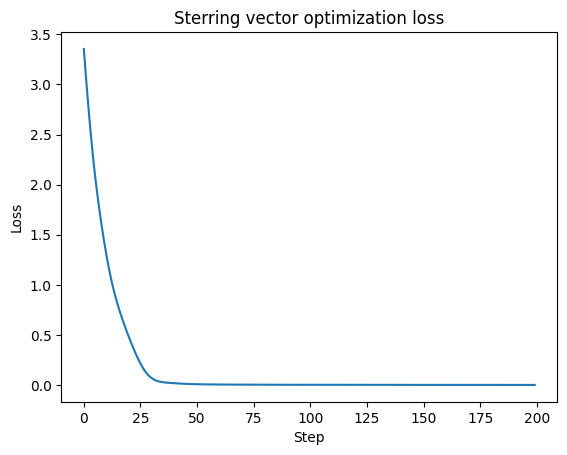

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt

# 1. SETUP
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# Now freezing the model. We are not training the model. We are finding the vector
for param in model.parameters():
    param.requires_grad = False
model.eval() # Set to eval mode (dropout off, etc.)

# 2. CONFIGURATION
# we are making the model to generate exactly this
target_sentence = "The weather is blue and the sky is green"
target_ids = tokenizer.encode(target_sentence, return_tensors="pt").to(device)
print(f"Target sentence: '{target_sentence}'")
print(f"Target IDs: {target_ids}")
print(f"Target Length: {target_ids.shape[1]} tokens")

# GPT2 has no pad token by default, Loss computation expects padding to be masked out
#
attention_mask = torch.ones(target_ids.shape, device=device)

# 3. LETS INJECT THE STEERING VECTOR OF SHAPE [1,1,768] FOR GPT2-SMALL
# We broadcast it across the sequence length, or add it to the first token.
# Subramani et al. often add it to all positions or specific layers.
embedding_dim = model.config.n_embd
steering_vector = nn.Parameter(torch.randn(1,1,embedding_dim).to(device), requires_grad=True)

# making optimizer only touch the steering vector
optimizer = optim.Adam([steering_vector], lr=0.1)

# We use a mutable container to track if the hook fires
hook_stats = {"fired": False}

# Now intervention via hook
# The below function will run inside the model, during forward pass
def steering_hook(module, input, output):
    hook_stats["fired"] = True
    # GPT-2 Blocks return a tuple: (hidden_states, present_key_values, ...)
    hidden_states = output[0]
    modified_hidden = hidden_states + steering_vector
    return (modified_hidden, ) + output[1:]

# we attach the hook to middle layers, because research shows middle layers are best
# to control high-level concepts best. We are adding our hook to the outputs of 6th layer
layer_idx = 6
hook_handle = model.transformer.h[layer_idx].register_forward_hook(steering_hook)

# performing Gradient descent to optimize the vector
num_steps = 200
loss_history = []

print("Starting optimization...")
for step in range(num_steps):
    optimizer.zero_grad()
    hook_stats["fired"] = False # Flag reset

    # We feed the model with target_ids, model predicts the token at every position
    # Then we compute the loss for those prediction and try to reduce them
    outputs = model(input_ids=target_ids, attention_mask=attention_mask, labels=target_ids)
    loss = outputs.loss
    loss.backward()
    # Checking if gradients exist
    if step == 0:
        if not hook_stats["fired"]:
            print("!!! ERROR: Hook did not fire. Check layer index.")
        if steering_vector.grad is None or steering_vector.grad.norm() == 0:
            print("!!! ERROR: Zero Gradients. The graph is broken.")
        else:
            print(f"Diagnostics Pass: Hook fired. Gradient norm: {steering_vector.grad.norm().item():.4f}")

    optimizer.step()

    loss_history.append(loss.item())
    if step % 20 ==0 :
        print(f"Step {step} | Loss: {loss.item():.4f}")

print("Optimization complete!")
hook_handle.remove()

# 4.GENERATION/VERIFICATION
print("Testing whether we can predict the target")

# re-attaching the hook for verification
hook_handle = model.transformer.h[layer_idx].register_forward_hook(steering_hook)

# Start with just the first word "The"
start_input = tokenizer.encode("The", return_tensors="pt").to(device)

# We set max_length to match the target length approx
output_ids = model.generate(
    start_input,
    max_new_tokens=10,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=False # Greedy
)

generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Target:    {target_sentence}")
print(f"Generated: {generated_text}")

#plotting loss to show convergence
plt.plot(loss_history)
plt.title("Sterring vector optimization loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

hook_handle.remove()

**Hernandez et al. (2023): "The Knowledge Editor"**


*   **Goal**: They wanted to find where facts (like "Paris is in France") are stored and edit them (make the model think "Paris is in Rome").
*   **Method**:


1.   They realized that relationships (like City $\to$ Country) often look like straight lines (linear) in the activation space.
2.   Gradient Descent (Jacobian): They used the model's gradients (specifically the derivative of the output with respect to the input) to mathematically calculate the "direction" of that fact.
3.   They found a vector that, when added to "Paris", shifts the activations to land on "Rome".


*   **Result:** They could "edit" the model's beliefs by injecting this vector.







The Experiment :


1.   **The Prompt**: "The Eiffel Tower is in" (Model expects "France").
2.   **The Goal**: Edit the model to believe it is in "Rome".
3.   **The Calculation**: Instead of training, we run one pass. We calculate the gradient of the word "Rome" with respect to the activations. This tells us: "Which direction do I push the neurons to make 'Rome' the most likely next word?"
4.   **The Injection**: We freeze the model and add this gradient vector (scaled) to the activation during inference.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader, Dataset

# --- 1. SETUP ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading model...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2-medium").to(device)
model.eval()

# Freeze GPT-2
for param in model.parameters():
    param.requires_grad = False

# --- 2. CREATE A "FORCED" TRAINING DATASET ---
# We use GENERIC prompts. The model relies 100% on the editor to know the city.
cities = [" Rome", " Paris", " London", " Tokyo", " Berlin", " Moscow", " Madrid", " Athens", " Beijing", " Cairo"]
templates = [
    "The city is",
    "It is located in",
    "The capital is",
    "This place is in",
    "We are traveling to"
]

training_data = []
for city in cities:
    for temp in templates:
        training_data.append((temp, city))

print(f"Created {len(training_data)} generic training pairs.")

class GenericDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = []
        for prompt, target in data:
            prompt_ids = tokenizer.encode(prompt, return_tensors="pt")[0]
            target_id = tokenizer.encode(target)[0]
            self.data.append((prompt_ids, target_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_loader = DataLoader(GenericDataset(training_data, tokenizer), batch_size=1, shuffle=True)

# --- 3. DEFINE THE REMEDI EDITOR ---
class REMEDIEditor(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        # Map Attribute Embedding -> Steering Vector
        # We use a 2-layer MLP for better expressiveness than a simple linear map
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward(self, attr_embedding):
        return self.net(attr_embedding)

editor = REMEDIEditor(model.config.n_embd).to(device)
optimizer = optim.Adam(editor.parameters(), lr=1e-3)

# --- 4. TRAIN THE EDITOR ---
# Layer 12 is the sweet spot for injecting facts in GPT-2 Medium
layer_target = 12

print(f"\n--- TRAINING REMEDI EDITOR (Layer {layer_target}) ---")
num_epochs = 15

for epoch in range(num_epochs):
    total_loss = 0
    for prompt_ids, target_id in train_loader:
        prompt_ids = prompt_ids.to(device)
        target_id = target_id.to(device)

        optimizer.zero_grad()

        # A. Get Hidden State of Generic Prompt
        with torch.no_grad():
            outputs = model(prompt_ids, output_hidden_states=True)
            # Hidden state at layer 12
            h_context = outputs.hidden_states[layer_target][:, -1, :]

        # B. Get Attribute Embedding (e.g., "Rome")
        with torch.no_grad():
            h_attr = model.transformer.wte(target_id)

        # C. Generate Steering Vector
        steering_vector = editor(h_attr)

        # D. Combine (The REMEDI Step)
        # We simulate the injection: Context + Vector
        h_edited = h_context + steering_vector

        # E. Pass through REST of the model to get predictions
        # We need a helper to run the model from Layer 12 onwards
        # But for simplicity in this script, we can map h_edited directly to logits using the head?
        # No, GPT-2 has layers 13-24 left.
        # TRICK: We approximate the loss by checking if the vector aligns with the target embedding
        # Or better: We assume the vector *is* the activation shift needed.

        # Robust Method: We need to pass h_edited through the rest of the model.
        # Since we can't easily chop the model in HuggingFace, we will use a Hook-based training step.

        # --- HOOK-BASED TRAINING STEP ---
        def train_hook(module, input, output):
            # Inject our vector during the forward pass
            # We add it to the output of the layer
            output[0][:, -1, :] = output[0][:, -1, :] + steering_vector
            return output

        # Attach hook
        h_handle = model.transformer.h[layer_target].register_forward_hook(train_hook)

        # Forward pass with injection
        out_train = model(prompt_ids)
        logits = out_train.logits[:, -1, :]

        loss = nn.CrossEntropyLoss()(logits, target_id)
        loss.backward()
        optimizer.step()

        h_handle.remove() # Crucial cleanup
        total_loss += loss.item()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")

# --- 5. TEST THE EDITOR ---
print("\n--- TESTING ON COUNTER-FACTUAL ---")
# Now we apply the learned editor to the specific "Eiffel Tower" case
test_prompt = "The Eiffel Tower is in"
target_attr = " Rome"

input_ids = tokenizer.encode(test_prompt, return_tensors="pt").to(device)
attr_id = tokenizer.encode(target_attr, return_tensors="pt")[0].to(device)

# 1. Get the Vector from Editor
with torch.no_grad():
    h_attr = model.transformer.wte(attr_id)
    final_steering_vector = editor(h_attr)
    print(f"Steering Vector Norm: {final_steering_vector.norm().item():.2f}")

# 2. Define Hook for Inference
def inference_hook(module, input, output):
    # We might need to scale it up because "Eiffel Tower" is a stronger context than "The city is"
    # Try strength 5.0 to 10.0
    strength = 10.0
    output[0][:, -1, :] += (final_steering_vector * strength)
    return output

# 3. Generate
hook_handle = model.transformer.h[layer_target].register_forward_hook(inference_hook)

print(f"Prompt: {test_prompt}")
output_ids = model.generate(input_ids, max_new_tokens=15, pad_token_id=tokenizer.eos_token_id, do_sample=False)
res = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Result: {res}")

hook_handle.remove()

# 4. Control Check
control_ids = model.generate(input_ids, max_new_tokens=15, pad_token_id=tokenizer.eos_token_id)
print(f"Control: {tokenizer.decode(control_ids[0], skip_special_tokens=True)}")

Using device: cuda
Loading model...
Created 50 generic training pairs.

--- TRAINING REMEDI EDITOR (Layer 12) ---
Epoch 5 | Loss: 0.0012
Epoch 10 | Loss: 0.0002
Epoch 15 | Loss: 0.0001
Training complete!

--- TESTING ON COUNTER-FACTUAL ---
Steering Vector Norm: 165.39
Prompt: The Eiffel Tower is in
Result: The Eiffel Tower is in Rome Rome Rome Rome Rome Rome Rome Rome Rome Rome Rome Rome Rome Rome Rome
Control: The Eiffel Tower is in Paris, France. The Eiffel Tower is in Paris, France.


This has worked to say Rome, but this looks like adding an additional neural net and training it to say Rome

## **Summary of Li et al. 2023b: Inference-Time Intervention (ITI)**

Central observation - **"knowing vs telling gap"**


*   Li et al. argue that models sometimes contain truth-relevant information internally but fail to express it in outputs.
*   A> **generation accuracy** (what the model answers), and B> **probe accuracy** (how well a classifier predicts truthfulness from internal activations).
*   On **TruthfulQA,** they report a large gap (≈40% in their LLaMA‑7B setup), suggesting internal representations can be much more truth-aware than outputs.

**About TruthfulQA dataset** -

The benchmark comprises questions that span 38 categories, including health, law, finance and politics.

**Data Fields**

* Type: Adversarial v Non-Adversarial Questions
* Category: Category of misleading question
* Question: The question
* Best Answer: The best correct answer
* Correct Answers: A set of correct answers. Delimited by ;.
* Incorrect Answers: set of incorrect answers.Delimited by ;
* Source: A source that supports the correct answers.

**Some other key findings**

*  some attention heads linearly encode truthfulness
*  They probe attention head activations (at the last token of the concatenated Q+A) with a linear classifier per head per layer.
*  Most heads are near chance, but a subset are highly predictive; they show strong head specialization across layers.
*  They also show “truthfulness” isn’t just one line; it looks like a subspace (they build an orthogonal second probe direction for visualization).

**Method**

1.   Rank heads by probe accuracy; select top‑K.
2.   For each selected head, define a truth direction (probe weight or mean-difference direction).
3.   During inference, add ασθ\alpha \sigma \thetaασθ to those head activations, where σ\sigmaσ is the standard deviation along that direction.
4.   Repeat autoregressively for each generated token.

**Results**

*  ITI substantially improves TruthfulQA performance (they emphasize a large boost, including on instruction-tuned variants).
*  The method is minimally invasive, computationally cheap, and adjustable via α\alphaα.
*  They observe a truthfulness ↔ helpfulness tradeoff, controllable by intervention strength.








1.   Locate where truthfullness is linearly represented
2.   Then train linear probes on internal activations(specifically , attention head activations) to classify whether a (question, answer) pair is truthful or false - because we will be using TruthfulQA
3.   Compute a “truthful direction” directly (no optimization loop at inference like subramani et al) - mean shift direction (difference between the means of truthful vs false activations)
4.   Apply that shift during inference, on a small set of heads
5.   During inference, they shift activations along truth-correlated directions for the top‑K heads, with strength α scaled by the activation standard deviation.
This intervention is repeated autoregressively for each generated token.





**Experiment to test Li et al. 2023b claims + Colab PyTorch code**

What we will test?

*  **Test 1 - "truthfulness is linearly decodable internally"** - Train a linear probe on internal activations to classify truthful vs false answer options.
Measure probe accuracy vs baseline generation

*  **Test 2 -** **“shifting activations along a truth direction improves truthfulness”** - Apply an ITI-like activation shift during scoring and see if TruthfulQA multiple-choice accuracy increases

*  **Test 3 - “there’s a tunable tradeoff (strength α)”**- Sweep α\alpha and plot TruthfulQA accuracy vs a “capability preservation” proxy (e.g., perplexity on WikiText-2 or average logprob).



In [7]:
!pip -q install transformers datasets accelerate

import types
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


MODEL_NAME = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

#In transformer models, attention is the most expensive and sensitive part of the computation.
# Over time, Hugging Face added multiple attention backends, each with different tradeoffs,
# like speed, memory usage, GPU support, numerical stability, pytorch compatability.
# attention_implementation = eager means — just do attention the normal PyTorch way
try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        attn_implementation="eager"
    ).to(device)
except TypeError:
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

model.eval()

n_layers = len(model.transformer.h)
n_heads = model.config.n_head
d_model = model.config.n_embd
head_dim = d_model // n_heads
print(f"Layers={n_layers}, Heads={n_heads}, d_model={d_model}, head_dim={head_dim}")

# Dataset: TruthfulQA multiple_choice
# HF provides only validation split for this config
full_ds = load_dataset("truthful_qa", "multiple_choice", split="validation")
splits = full_ds.train_test_split(test_size=0.30, seed=SEED, shuffle=True)
train_q = splits["train"]
test_q = splits["test"]
print("Questions train:", len(train_q), "test:", len(test_q))

# Probe examples from MC1
@dataclass
class ProbeExample:
    text: str
    y: int

def build_probe_examples(question_ds, n_questions=300, target_key="mc1_targets", seed=0) -> List[ProbeExample]:
    rng = random.Random(seed)
    idxs = list(range(len(question_ds)))
    rng.shuffle(idxs)
    idxs = idxs[:min(n_questions, len(question_ds))]

    out = []
    for i in idxs:
        ex = question_ds[i]
        q = ex["question"]
        prompt = f"Q: {q}\nA:"
        choices = ex[target_key]["choices"]
        labels = ex[target_key]["labels"]
        for c, lab in zip(choices, labels):
            out.append(ProbeExample(text=prompt + " " + c.strip(), y=int(lab)))
    rng.shuffle(out)
    return out

probe_examples = build_probe_examples(train_q, n_questions=300, seed=SEED)
print("Probe examples:", len(probe_examples), "Pos rate:", np.mean([e.y for e in probe_examples]))

# Split probe examples into probe-train/probe-val for head ranking
idx = np.arange(len(probe_examples))
np.random.shuffle(idx)
split = int(0.8 * len(idx))
probe_train = [probe_examples[i] for i in idx[:split]]
probe_val = [probe_examples[i] for i in idx[split:]]
print("Probe train:", len(probe_train), "Probe val:", len(probe_val))


# ============================================================
# ITI(Inference tim intervention) State
# ITIState is a global controller that remembers attention head activations, stores learned intervention
# directions, and decides when and how strongly to nudge selected attention heads during inference.
class ITIState:
    def __init__(self, n_layers, n_heads, head_dim):
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.head_dim = head_dim

        # Runtime switches
        self.collect = False # Whether to record head activations
        self.active = False  # Whether to apply ITI intervention
        self.alpha = 0.0     # Strength of the intervention
        # During probing → collect = True & During inference → active = True

        # Learned ITI parameters
        self.theta = None   # [L,H,D] - Unit direction for each head (probe weight direction)
        self.sigma = None    # [L,H] - Std dev of projection along theta
        self.selected = None # [L,H] - Which heads are allowed to be intervened on

        # One list per layer in the shape [B,H,D], later concatenated as [N,L,H,D]
        self._cache = [[] for _ in range(n_layers)]

    # FIX: These must be real class methods (not nested inside __init__)
    def reset_cache(self):
        self._cache = [[] for _ in range(self.n_layers)]

    # Patched attention forward
    # Receives per-layer head outputs: [B,H,D] -> Detaches from computation graph
    # Moves to CPU (saves GPU memory) -> Appends to that layer’s cache
    def push(self, layer_idx, vec_bhd):
        self._cache[layer_idx].append(vec_bhd.detach().cpu())

    # Build final activation tensor
    def pop_all(self):
        layers = []
        for l in range(self.n_layers):
            # Each entry was [B,H,D] -> After concat [N,H,D]
            x = torch.cat(self._cache[l], dim=0) if len(self._cache[l]) else torch.empty(0, self.n_heads, self.head_dim)
            layers.append(x) # [N, H, D] pre layer
        return torch.stack(layers, dim=1)  # [N, L, H, D], n- no of probe examples

iti = ITIState(n_layers, n_heads, head_dim)

# Some HELPER functions

def split_heads(x, n_heads, head_dim):
    # x: [B, T, d_model] -> [B, H, T, D] ( T is sequence length/ no of tokens)
    B, T, C = x.shape
    return x.view(B, T, n_heads, head_dim).permute(0, 2, 1, 3).contiguous()
    # contiguous ensures tensor is laid out correctly in memory

def merge_heads(x):
    # x: [B, H, T, D] -> [B, T, d_model]
    B, H, T, D = x.shape
    return x.permute(0, 2, 1, 3).contiguous().view(B, T, H * D)

# In normal causal mask -> Tq == Tk == sequence length -> Mask is simple lower traingle
# In cached causal mask -> Tk = past_tokens + current_tokens and Tq = current_tokens only

def make_causal_mask(Tq, Tk, device):
    # For cached attention, keys are longer than queries
    # Allow each query position to attend to all keys upto its aligned positioninthe full key sequence
    # Q positions corresponds to last Tq keys: offset = Tk - Tq
    qpos = torch.arange(Tq, device=device) + (Tk - Tq)
    kpos = torch.arange(Tk, device=device)
    # PyTorch broadcasting
    mask = kpos[None, :] <= qpos[:, None]  #[Tq, Tk]
    return mask
    # For [2,5] shape, mask looks something like this, mask =
    # [
    #   [ True, True, True, True, False ],
    #   [ True, True, True, True, True  ]]

def expand_attention_mask(attention_mask, dtype):

    if attention_mask is None:
        return None

    if attention_mask.dim() == 2:
        # [B,T] -> additive [B,1,1,T]
        # keep=1 => add 0, pad=0 => add -inf
        am = attention_mask.to(dtype=dtype)
        am = (1.0 - am) * torch.finfo(dtype).min
        return am[:, None, None, :]

    if attention_mask.dim() == 4:
        return attention_mask.to(dtype=dtype)

    return None

# ============================================================
# Patch GPT2Attention.forward (robust)
# It replaces GPT-2’s attention forward function with a custom one that can
# (a) collect per-head activations and
# (b) inject ITI interventions — without breaking GPT-2.

def patch_gpt2_attention_for_iti(model, iti_state: ITIState):

    for layer_idx, block in enumerate(model.transformer.h):
        attn = block.attn

        # Restore if already patched
        if hasattr(attn, "_original_forward"):
            attn.forward = attn._original_forward
        # Python looks at the object attn. It asks: "Does this object have a property named _original_forward saved inside it?"
        # If Yes: It executes the next line, which resets the forward method back to its original state.
        attn.layer_idx = layer_idx
        attn._original_forward = attn.forward

        # New attention forward
        def iti_forward(self,
                        hidden_states,
                        past_key_values=None,
                        layer_past=None,
                        cache_position=None,
                        attention_mask=None,
                        head_mask=None,
                        use_cache=False,
                        output_attentions=False,
                        **kwargs):
            # HF's transformers library uses different names to hold KV cache, older versions use layer_past
            # Newer versions like different models (Llama, Mistral, etc.) now use the variable name past_key_values
            layer_past = past_key_values if past_key_values is not None else layer_past

            # A standard Linear layer stores its weights as [out_features, in_features]
            # GPT-2’s Conv1D layer stores weights as [in_features, out_features]
            qkv = self.c_attn(hidden_states)
            query, key, value = qkv.split(d_model, dim=2) # each [B,T,d_model]

            # Split heads
            q = split_heads(query, n_heads, head_dim) # [B,H,Tq,D]
            k = split_heads(key, n_heads, head_dim)   # [B,H,Tk,D]
            v = split_heads(value, n_heads, head_dim) # [B,H,Tk,D]

            # Append cache
            if layer_past is not None:
                past_k, past_v = layer_past # [B,H,Tpast,D]
                k = torch.cat([past_k, k], dim=2)
                v = torch.cat([past_v, v], dim=2)

            present = (k, v) if use_cache else None

            B, H, Tq, D = q.shape
            Tk = k.size(2)

            # Scaled dot-product attention scores: [B,H,Tq,Tk]
            scale = 1.0 / np.sqrt(D)
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) * scale

            # Causal mask
            causal = make_causal_mask(Tq, Tk, device=attn_scores.device) # [Tq,Tk]
            attn_scores = attn_scores.masked_fill(~causal[None, None, :, :], torch.finfo(attn_scores.dtype).min)

            # Add external attention mask (padding)
            am = expand_attention_mask(attention_mask, attn_scores.dtype)
            if am is not None:
                # am is [B, 1, 1, Tk] additive
                attn_scores = attn_scores + am

            attn_weights = F.softmax(attn_scores, dim=-1)

            # Optional head mask (rarely used)
            if head_mask is not None:
                # head_mask can be [H] or [L,H]; handle [H] case
                if head_mask.dim() == 1:
                    attn_weights = attn_weights * head_mask.view(1, -1, 1, 1)
                elif head_mask.dim() == 2:
                    attn_weights = attn_weights * head_mask[self.layer_idx].view(1, -1, 1, 1)

            # Dropout (if exists)
            if hasattr(self, "attn_dropout") and self.attn_dropout is not None:
                attn_weights = self.attn_dropout(attn_weights)

            # Head outputs: [B,H,Tq,D]
            attn_output = torch.matmul(attn_weights, v)

            # -------- Collect last-token head activations --------
            if iti_state.collect:
                # use original 2D mask if available, otherwise last token
                if attention_mask is not None and attention_mask.dim() == 2:
                    last_idx = torch.clamp(attention_mask.long().sum(dim=-1)-1, min=0)
                # [B]
                else:
                    # FIX: device should be attn_output.device, not the tensor itself
                    last_idx = torch.full((B,), Tq-1, device=attn_output.device, dtype=torch.long)
                b = torch.arange(B, device=attn_output.device)
                vec_bhd = attn_output[b, :, last_idx, : ] # [B,H,D]
                # FIX: actually push to cache
                iti_state.push(self.layer_idx, vec_bhd)

            # ITI intervention in Head space -----------------------
            if iti_state.active and iti_state.theta is not None and iti_state.selected is not None:
                l = self.layer_idx
                sel = iti_state.selected[l] # [H] Bool
                if sel.any():
                    theta_l = iti_state.theta[l] # [H,D]
                    sigma_l = iti_state.sigma[l] # [H]
                    delta = torch.zeros((n_heads, head_dim), device=attn_output.device, dtype=attn_output.dtype)
                    # FIX: theta_l[sel], not theta_l(sel)
                    delta[sel] = (iti_state.alpha * sigma_l[sel]).unsqueeze(-1) * theta_l[sel]
                    attn_output = attn_output + delta.view(1, n_heads, 1, head_dim)

            # Merge heads + output projection
            attn_output = merge_heads(attn_output) # [B,Tq,d_model]
            attn_output = self.c_proj(attn_output) # [B,Tq,d_model]
            if hasattr(self, "resid_dropout") and self.resid_dropout is not None:
                attn_output = self.resid_dropout(attn_output)
            outputs = (attn_output, present)
            if output_attentions:
                outputs = outputs + (attn_weights,)
            return outputs

        attn.forward = types.MethodType(iti_forward, attn)

patch_gpt2_attention_for_iti(model, iti)
print("Patched GPT-2 attention for per-head ITI")


# ============================================================
# Collect per-head activations X: [N,L,H,D] on probe dataset

@torch.no_grad()
def collect_head_activations(examples: List[ProbeExample], batch_size=16, max_length=256) -> Tuple[torch.Tensor, torch.Tensor]:
    iti.reset_cache()
    iti.collect = True
    iti.active = False

    ys = []
    for i in range(0, len(examples), batch_size):
        batch = examples[i:i+batch_size]
        texts = [t.text for t in batch]
        # FIX: torch.tensor instead of torch.Tensor
        ys.append(torch.tensor([t.y for t in batch], dtype=torch.float32))
        enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        _ = model(**enc, use_cache=False, return_dict=True)

    iti.collect = False
    y = torch.cat(ys, dim=0)
    X = iti.pop_all() # Retrieves the cached data: One big tensor of shape [B, Layers, Heads, Dim]
    return X, y


Xtr, ytr = collect_head_activations(probe_train, batch_size=16)
Xva, yva = collect_head_activations(probe_val, batch_size=16)
print("Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("Xva:", Xva.shape, "yva:", yva.shape)

Xtr = Xtr.to(device).float()
ytr = ytr.to(device).float()
Xva = Xva.to(device).float()
yva = yva.to(device).float()

# Training per-head probes simultaneously
W = nn.Parameter(torch.zeros(n_layers, n_heads, head_dim, device=device))
bb = nn.Parameter(torch.zeros(n_layers, n_heads, device=device))
opt = torch.optim.AdamW([W, bb], lr=2e-2)
loss_fn = nn.BCEWithLogitsLoss()

def logits_from(X):
    return (X * W.unsqueeze(0)).sum(dim=-1) + bb.unsqueeze(0)

EPOCHS = 8
for epoch in range(1,EPOCHS+1):
    opt.zero_grad()
    lg = logits_from(Xtr)
    loss = loss_fn(lg.reshape(-1), ytr.view(-1,1,1).expand_as(lg).reshape(-1))
    loss.backward()
    opt.step()

    with torch.no_grad():
        va_lg = logits_from(Xva)
        va_pred = (torch.sigmoid(va_lg)>0.5).float()
        va_y = yva.view(-1,1,1).expand_as(va_lg)
        head_acc = (va_pred == va_y).float().mean(dim=0) # [L,H]
        best = head_acc.max().item()
    print(f"Epoch {epoch}/{EPOCHS} | loss={loss.item():.4f} | best_head_val_acc={best:.3f}")

# ============================================================
# Select top-K heads by validation probe accuracy (sparse intervention)
K = 48
flat_acc = head_acc.reshape(-1)
topk = torch.topk(flat_acc, k=min(K, flat_acc.numel()))
# FIX: torch.bool not torch.book
selected = torch.zeros_like(flat_acc, dtype=torch.bool)
selected[topk.indices] = True
selected = selected.view(n_layers, n_heads)
print("Selected heads:", int(selected.sum().item()), "Best head acc:", float(topk.values[0].item()))


# ============================================================
# Build theta (unit probe direction) and sigma (std along theta) like ITI
with torch.no_grad():
    theta = W.detach().clone()
    theta = theta/(theta.norm(dim=-1, keepdim=True) + 1e-8) # [L,H,D]
    Xall = torch.cat([Xtr,Xva], dim=0)
    proj = (Xall * theta.unsqueeze(0)).sum(dim=-1) # [N,L,H]
    sigma = proj.std(dim=0).clamp(min=1e-6) #[L,H]

iti.theta = theta
iti.sigma = sigma
iti.selected = selected

# ============================================================
# Multiple-choice evaluation via conditional logprob

@torch.no_grad()
def conditional_logprob(prompt: str, completion: str) -> float:
    full = prompt + completion
    enc_full = tokenizer(full, return_tensors="pt").to(device)
    input_ids = enc_full["input_ids"]
    attn_mask = enc_full["attention_mask"]
    out = model(input_ids=input_ids, attention_mask=attn_mask, use_cache=False, return_dict=True)
    logits = out.logits

    logp = torch.log_softmax(logits[:, :-1, :], dim=-1)
    target = input_ids[:, 1:]

    prompt_len = tokenizer(prompt, return_tensors="pt")["input_ids"].shape[1]
    start = max(prompt_len - 1, 0)
    token_lops = logp[0, start:, :].gather(1, target[0, start:].unsqueeze(-1)).squeeze(-1)

    # FIX: return the score
    return float(token_lops.sum().item())

def mc_accuracy(question_ds, max_items=200, target_key="mc1_targets")-> float:
    n = min(max_items, len(question_ds))
    correct = 0
    for i in range(n):
        ex = question_ds[i]
        q = ex["question"]
        choices = ex[target_key]["choices"]
        labels = ex[target_key]["labels"]
        gold = int(np.argmax(labels))

        prompt = f"Q: {q}\nA:"
        scores = [conditional_logprob(prompt, " " + c.strip()) for c in choices]
        pred = int(np.argmax(scores))

        # FIX: update correct count
        correct += int(pred == gold)

    return correct / n

# Baseline
iti.active = False
iti.alpha = 0.0
base = mc_accuracy(test_q, max_items=200)
print("\nBaseline MC1 accuracy (n=200):", base)

# ITI alpha sweep
for a in [0.0, 0.5, 1.0, 2.0, 3.0]:
    iti.active = (a != 0.0)
    iti.alpha = float(a)
    acc = mc_accuracy(test_q, max_items=200)
    print(f"ITI alpha={a:>3}: MC1 accuracy={acc:.3f}")

Device: cuda


Loading weights:   0%|          | 0/292 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2-medium
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...23}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Layers=24, Heads=16, d_model=1024, head_dim=64
Questions train: 571 test: 246
Probe examples: 1515 Pos rate: 0.19801980198019803
Probe train: 1212 Probe val: 303
Patched GPT-2 attention for per-head ITI
Xtr: torch.Size([1212, 24, 16, 64]) ytr: torch.Size([1212])
Xva: torch.Size([303, 24, 16, 64]) yva: torch.Size([303])
Epoch 1/8 | loss=0.6931 | best_head_val_acc=0.802
Epoch 2/8 | loss=0.6624 | best_head_val_acc=0.802
Epoch 3/8 | loss=0.6364 | best_head_val_acc=0.802
Epoch 4/8 | loss=0.6138 | best_head_val_acc=0.802
Epoch 5/8 | loss=0.5944 | best_head_val_acc=0.802
Epoch 6/8 | loss=0.5777 | best_head_val_acc=0.802
Epoch 7/8 | loss=0.5636 | best_head_val_acc=0.802
Epoch 8/8 | loss=0.5519 | best_head_val_acc=0.802
Selected heads: 48 Best head acc: 0.801980197429657

Baseline MC1 accuracy (n=200): 0.22
ITI alpha=0.0: MC1 accuracy=0.220
ITI alpha=0.5: MC1 accuracy=0.225
ITI alpha=1.0: MC1 accuracy=0.230
ITI alpha=2.0: MC1 accuracy=0.235
ITI alpha=3.0: MC1 accuracy=0.240
